<a href="https://colab.research.google.com/github/jordantab/11785-assignment-part2s/blob/main/HW2P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

# Libraries

In [ ]:
!nvidia-smi # Run this to see what GPU you have

Fri Oct 11 04:35:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install wandb --quiet # Install WandB
!pip install pytorch_metric_learning --quiet #Install the Pytorch Metric Library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.8/313.8 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 4.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
from pytorch_metric_learning import losses
import csv
from torchvision.transforms import v2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [ ]:
from google.colab import drive # Link to your drive if you are not using Colab with GCP
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

Mounted at /content/drive


# Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"jordantab","key":"6012317c8cbe2756d1bf461f146b1d6e"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73248 sha256=214917d62c1a8177cecedcb2f3c407bfdd6957cb16abbe1e16067679249e770c
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [ ]:
# # Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/content/data'

!kaggle competitions download -c 11785-hw-2-p-2-face-verification-fall-2024
!unzip -qo '11785-hw-2-p-2-face-verification-fall-2024.zip' -d '/content/data'

100% 2.74G/2.75G [00:10<00:00, 298MB/s]
100% 2.75G/2.75G [00:10<00:00, 271MB/s]


# Config

In [ ]:
run_name = "convnext-t-7"

checkpoint_dir = f"/content/drive/My Drive/hw2p2/checkpoints/{run_name}"
os.makedirs(checkpoint_dir, exist_ok=True)

config = {
    'batch_size': 512, # Increase this if your GPU can handle it
    'p': 0.5,
    'degrees': 10,
    'brightness': 0.1,
    'contrast': 0.1,
    'saturation': 0.1,
    'hue': 0.05,
    'lr':  0.1,
    'factor': 0.1,
    'weight_decay': 0.1,
    'epochs': 100, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'data_dir': "data/11-785-f24-hw2p2-verification/cls_data",
    'data_ver_dir': "data/11-785-f24-hw2p2-verification/ver_data",
    'checkpoint_dir': checkpoint_dir,
    'run_name': run_name
    # Include other parameters as needed.
}

In [ ]:
print(os.path.exists('data/11-785-f24-hw2p2-verification'))

True


# Dataset

## Dataset Class for doing Image Verification

In [ ]:
class ImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2, match = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2), int(match)

In [ ]:
class TestImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2 = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2)

## Create Dataloaders for Image Recognition

In [ ]:
data_dir = config['data_dir']
# train_dir = os.path.join(data_dir)

train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'dev')

# train transforms
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112), # Why are we resizing the Image?
    torchvision.transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    torchvision.transforms.RandomHorizontalFlip(p=config['p']),
    torchvision.transforms.RandomRotation(degrees=config['degrees']),
    torchvision.transforms.ColorJitter(brightness=config['brightness'], contrast=config['contrast'], saturation=config['saturation'], hue=config['hue']),
    torchvision.transforms.RandomResizedCrop(size=112, scale=(0.8, 1.0)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                      std=[0.5, 0.5, 0.5])])

# val transforms
val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                      std=[0.5, 0.5, 0.5])])


# get datasets
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=config["batch_size"],
                                            shuffle=True,
                                            pin_memory=True,
                                            num_workers=8,
                                            sampler=None)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=False,
                                          num_workers=4)

In [ ]:
data_dir = config['data_ver_dir']

# get datasets

# TODO: Add your validation pair txt file
pair_dataset = ImagePairDataset(data_dir, csv_file='data/11-785-f24-hw2p2-verification/val_pairs.txt', transform=val_transforms)
pair_dataloader = torch.utils.data.DataLoader(pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# TODO: Add your validation pair txt file
test_pair_dataset = TestImagePairDataset(data_dir, csv_file='data/11-785-f24-hw2p2-verification/test_pairs.txt', transform=val_transforms)
test_pair_dataloader = torch.utils.data.DataLoader(test_pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# EDA and Viz

In [ ]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  512
Train batches        :  843
Val batches          :  85


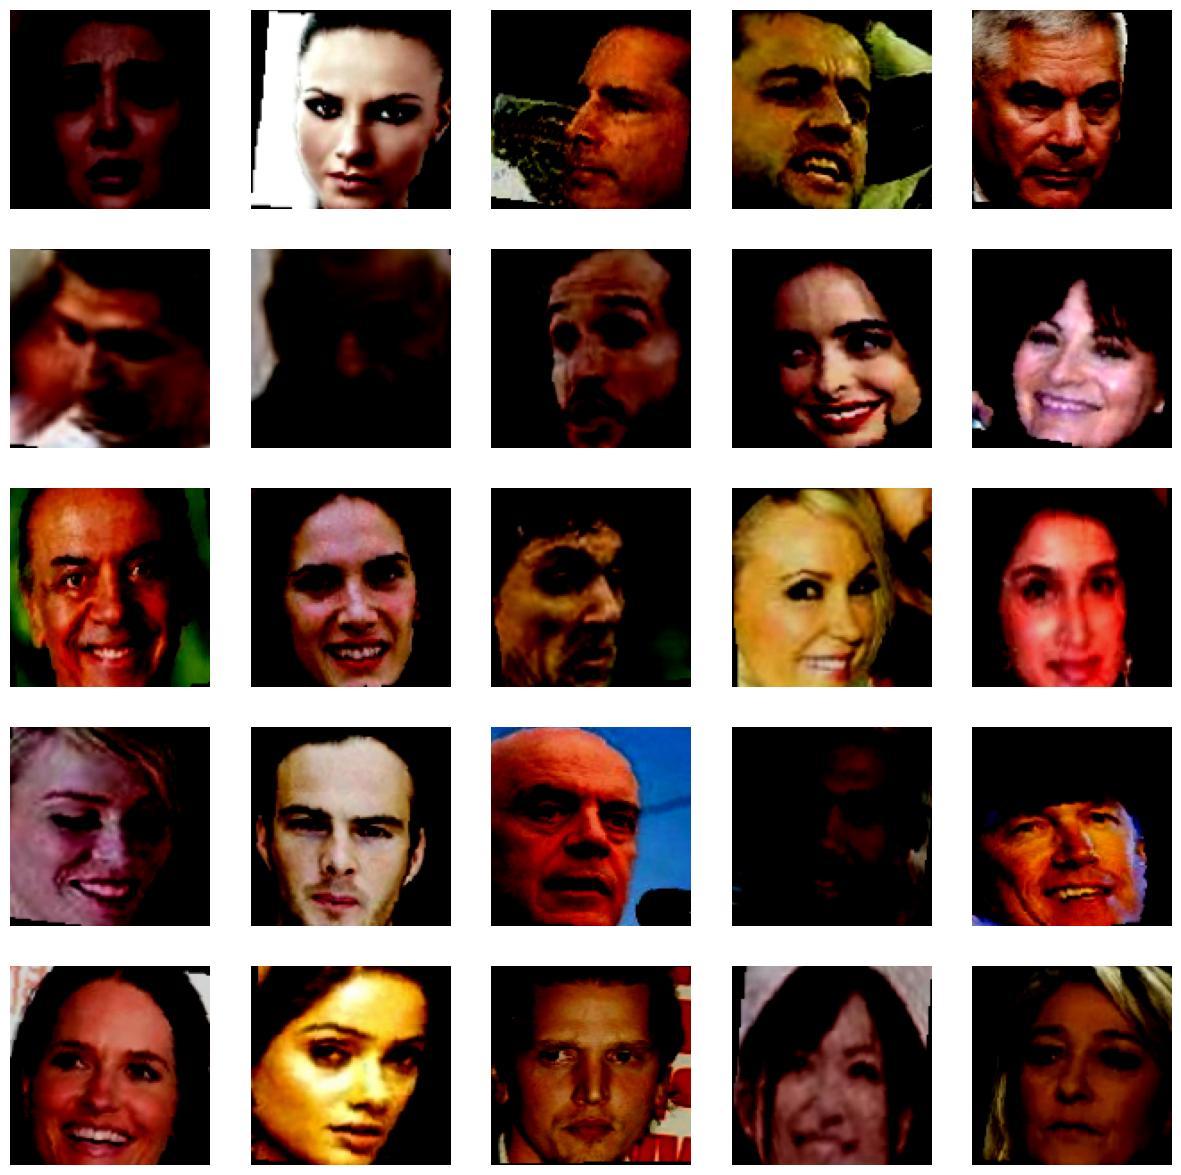

In [ ]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(train_dir, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit is 18M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [ ]:
# # Residual Block for ResNet

# class ResidualBlock(torch.nn.Module):
#   expansion = 1

#   def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#     super(ResidualBlock, self).__init__()
#     self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1), torch.nn.BatchNorm2d(out_channels), torch.nn.ReLU())
#     self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1), torch.nn.BatchNorm2d(out_channels))
#     self.downsample = downsample
#     self.relu = torch.nn.ReLU()

#   def forward(self, x):
#     residual = x

#     # First convolutional layer
#     out = self.conv1(x)

#     # Second convolutional layer
#     out = self.conv2(out)

#     if self.downsample is not None:
#       residual = self.downsample(x)

#     out += residual
#     out = self.relu(out)

#     return out

In [ ]:
# # Residual Block for ResNet-50

# class ResidualBlock(torch.nn.Module):
#   expansion = 4

#   def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#     super(ResidualBlock, self).__init__()
#     print(in_channels, out_channels)
#     self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size=1), torch.nn.BatchNorm2d(out_channels), torch.nn.ReLU())
#     self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1), torch.nn.BatchNorm2d(out_channels), torch.nn.ReLU())
#     self.conv3 = torch.nn.Sequential(torch.nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1), torch.nn.BatchNorm2d(out_channels * self.expansion))
#     self.downsample = downsample
#     self.relu = torch.nn.ReLU()

#   def forward(self, x):
#     residual = x

#     # First convolutional layer (bottleneck)
#     out = self.conv1(x)

#     # Second convolutional layer
#     out = self.conv2(out)

#     # Third convolutional layer
#     out = self.conv3(out)

#     if self.downsample is not None:
#       residual = self.downsample(x)

#     out += residual
#     out = self.relu(out)

#     return out

In [ ]:
# # ResNet Architecture stacking together blocks
# class ResNet(torch.nn.Module):
#   def __init__(self, block, layers, num_classes=8631):
#     super(ResNet, self).__init__()
#     self.in_channels = 64

#     # Initial convolution and pooling layers
#     self.conv1 = torch.nn.Sequential(
#       torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
#       torch.nn.BatchNorm2d(64),
#       torch.nn.ReLU())
#     self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#     # Residual blocks
#     self.layer1 = self._make_layer(block, 64, layers[0], 1)
#     self.layer2 = self._make_layer(block, 128, layers[1], 2, stride=2)
#     self.layer3 = self._make_layer(block, 256, layers[2], 3, stride=2)
#     self.layer4 = self._make_layer(block, 512, layers[3], 4, stride=2)

#     # Average pooling and fully connected layer
#     self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
#     self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

#   def _make_layer(self, block, out_channels, blocks, i, stride=1):
#     downsample = None
#     if stride != 1 or self.in_channels != out_channels * block.expansion:
#       downsample = torch.nn.Sequential(
#           torch.nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=
#                           1, stride=stride),
#           torch.nn.BatchNorm2d(out_channels * block.expansion)
#       )

#     layers = []
#     layers.append(block(self.in_channels, out_channels, stride, downsample))
#     self.in_channels = out_channels * block.expansion
#     for i in range(1, blocks):
#       layers.append(block(self.in_channels, out_channels))

#     return torch.nn.Sequential(*layers)

#   def forward(self, x):
#         x = self.conv1(x)
#         x = self.maxpool(x)
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         feats = x
#         out = self.fc(x)

#         return {"feats": feats, "out": out}

# model = ResNet(ResidualBlock, [3,4,6,3]).to(DEVICE)
# summary(model, (3, 112, 112))

64 64
256 64
256 64
256 128
512 128
512 128
512 128
512 256
1024 256
1024 256
1024 256
1024 256
1024 256
1024 512
2048 512
2048 512
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,472
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
         MaxPool2d-4           [-1, 64, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]           4,160
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,928
       BatchNorm2d-9           [-1, 64, 28, 28]             128
             ReLU-10           [-1, 64, 28, 28]               0
           Conv2d-11          [-1, 256, 28, 28]          16,640
      BatchNorm2d-12          [-1, 

In [ ]:
# Building block for ConvNeXt

class ConvNeXtBlock(nn.Module):
  def __init__(self, dim):
    super(ConvNeXtBlock, self).__init__()

    # Depthwise convolution
    self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)

    # Pointwise convolutions
    self.pwconv1 = nn.Linear(dim, 4 * dim)
    self.pwconv2 = nn.Linear(4 * dim, dim)

    # Normalization and activation
    self.ln = nn.LayerNorm(dim, eps=1e-6)
    self.gelu = nn.GELU()

  def forward(self, x):
    input = x

    x = self.dwconv(x)
    x = x.permute(0, 2, 3, 1)
    x = self.ln(x)
    x = self.pwconv1(x)
    x = self.gelu(x)
    x = self.pwconv2(x)
    x = x.permute(0, 3, 1, 2)
    x = x + input

    return x

In [ ]:
# Permute class

class Permute(nn.Module):
    def __init__(self, *dims):
        super(Permute, self).__init__()
        self.dims = dims

    def forward(self, x):
        return x.permute(*self.dims)

In [ ]:
# ConvNeXt-T architecture based on 'A ConvNet for the 2020s' (https://arxiv.org/abs/2201.03545)

class ConvNeXt(nn.Module):
  def __init__(self, in_channels=3, num_classes=8631, depths=[3, 3, 9, 3], dims=[96, 192, 384, 768]):
    super(ConvNeXt, self).__init__()

    # Downsampling layers initilization
    self.downsampling_layers = nn.ModuleList()

    # Stem layer
    stem = nn.Sequential(
        nn.Conv2d(in_channels, dims[0], kernel_size=4, stride=4),
        Permute(0, 2, 3, 1),
        nn.LayerNorm(dims[0], eps=1e-6),
        Permute(0, 3, 1, 2),
    )
    self.downsampling_layers.append(stem)

    # Downsampling layers
    for i in range(3):
      downsampling_layer = nn.Sequential(
          Permute(0, 2, 3, 1),
          nn.LayerNorm(dims[i], eps=1e-6),
          Permute(0, 3, 1, 2),
          nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2)
      )
      self.downsampling_layers.append(downsampling_layer)

    # Stages
    self.stages = nn.ModuleList()
    for i in range(4):
      stage = nn.Sequential(
          *[ConvNeXtBlock(dims[i]) for _ in range(depths[i])]
      )
      self.stages.append(stage)

    # Final normalization and classification head
    self.norm = nn.LayerNorm(dims[-1], eps=1e-6)
    self.head = nn.Linear(dims[-1], num_classes)

  def forward(self, x):
    for i in range(4):
      # Downsample between stages
      x = self.downsampling_layers[i](x)
      x = self.stages[i](x)
    x = x.mean([-2, -1])
    feats = x
    x = self.norm(x)
    out = self.head(x)

    return {"feats": feats, "out": out}

model = ConvNeXt().to(DEVICE)
summary(model, input_size=(3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 28, 28]           4,704
           Permute-2           [-1, 28, 28, 96]               0
         LayerNorm-3           [-1, 28, 28, 96]             192
           Permute-4           [-1, 96, 28, 28]               0
            Conv2d-5           [-1, 96, 28, 28]           4,800
         LayerNorm-6           [-1, 28, 28, 96]             192
            Linear-7          [-1, 28, 28, 384]          37,248
              GELU-8          [-1, 28, 28, 384]               0
            Linear-9           [-1, 28, 28, 96]          36,960
    ConvNeXtBlock-10           [-1, 96, 28, 28]               0
           Conv2d-11           [-1, 96, 28, 28]           4,800
        LayerNorm-12           [-1, 28, 28, 96]             192
           Linear-13          [-1, 28, 28, 384]          37,248
             GELU-14          [-1, 28, 

In [ ]:
# --------------------------------------------------- #

# Defining Loss function
criterion = torch.nn.CrossEntropyLoss()
# criterion = losses.ArcFaceLoss(num_classes=8631, embedding_size=512, margin=config['margin_size'], scale=config['scale'])

# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr= config['lr'])
# optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'], )
# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=config['factor'], patience=config['patience'])
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=config['T_0'], T_mult=['T_mult'])
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config['lr'], epochs=config['epochs'], steps_per_epoch=len(train_loader))
# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

<ipython-input-232-5703da0432cb>:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


# Metrics

In [ ]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [ ]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# Train and Validation Function

In [ ]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)

        # forward
        with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
            outputs = model(images)

            # Use the type of output depending on the loss function you want to use
            loss = criterion(outputs['out'], labels)

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()
        # metrics
        loss_m.update(loss.item())
        if 'feats' in outputs:
            acc = accuracy(outputs['out'], labels)[0].item()
        else:
            acc = 0.0
        acc_m.update(acc)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100*accuracy),
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

    # You may want to call some schedulers inside the train function. What are these?
    if lr_scheduler is not None:
        lr_scheduler.step()

    batch_bar.close()

    return acc_m.avg, loss_m.avg

In [ ]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs['out'], labels)

        # metrics
        acc = accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py:2388: UserWarning: Run (xcq6kz1e) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),


# Verification Task

In [ ]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC'], metric_dict['EER']

# WandB

In [ ]:
wandb.login(key="4c68592a14802648ff3220711294d6e5fe7d272f") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name = config['run_name'], ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # id = gen_id, ### Insert specific run id here if you want to resume a previous run
    # resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config, ### Wandb Config for your run
)

# Checkpointing and Loading Model

In [ ]:
# Uncomment the line for saving the scheduler save dict if you are using a scheduler
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

In [ ]:
print(os.path.exists("best_cls.pth"))

False


# Load Pre-Trained Model

In [ ]:
# from pytorch_metric_learning import losses
model, optimizer, scheduler, epoch, metrics = load_model(model, optimizer, scheduler, "best_ret (1).pth")

# optimizer = torch.optim.SGD(model.parameters(), lr=0.09989011473116477)

<ipython-input-117-917ec4f96c61>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


FileNotFoundError: [Errno 2] No such file or directory: 'best_ret (1).pth'

In [ ]:
criterion = losses.ArcFaceLoss(num_classes=8631, embedding_size=512, margin=config['margin_size'], scale=config['scale'])
optimizer = torch.optim.SGD(criterion.parameters(), lr=config['lr'], weight_decay=config['weight_decay'], momentum=config['momentum'])
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config['lr'], epochs=config['epochs'], steps_per_epoch=len(train_loader))

KeyError: 'momentum'

# Experiments

In [ ]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

        # train
        train_cls_acc, train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics = {
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        }
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, val_loader, DEVICE, config)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })
            scheduler.step(valid_loss)

        # retrieval validation
        valid_ret_acc, valid_eer = valid_epoch_ver(model, pair_dataloader, DEVICE, config)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc,
            'valid_eer': valid_eer,
            'lr': curr_lr
        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")

        # log to tracker
        if run is not None:
            run.log(metrics)


Epoch 1/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 1/100: 
Train Cls. Acc 0.0447%	 Train Cls. Loss 8.9350	 Learning Rate 0.1000


Val Cls. Acc 0.1448%	 Val Cls. Loss 8.6263


{'ACC': 59.5, 'EER': 41.06090373289313, 'AUC': 62.27217618508397, 'TPRs': [('TPR@FPR=1e-4', 0.20366598778004072), ('TPR@FPR=5e-4', 0.20366598778004072), ('TPR@FPR=1e-3', 0.20366598778004072), ('TPR@FPR=5e-3', 2.240325865580448), ('TPR@FPR=5e-2', 13.441955193482688)]}
Val Ret. Acc 59.5000%
Saved epoch model


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Saved best classification model
Saved best retrieval model

Epoch 2/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 2/100: 
Train Cls. Acc 0.2988%	 Train Cls. Loss 8.4176	 Learning Rate 0.0999


Val Cls. Acc 0.6595%	 Val Cls. Loss 8.1285


{'ACC': 63.1, 'EER': 37.52455795685721, 'AUC': 67.34021823070675, 'TPRs': [('TPR@FPR=1e-4', 0.6109979633401221), ('TPR@FPR=5e-4', 0.6109979633401221), ('TPR@FPR=1e-3', 0.6109979633401221), ('TPR@FPR=5e-3', 4.480651731160896), ('TPR@FPR=5e-2', 16.4969450101833)]}
Val Ret. Acc 63.1000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 3/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 3/100: 
Train Cls. Acc 1.0976%	 Train Cls. Loss 7.9394	 Learning Rate 0.0998


Val Cls. Acc 1.8449%	 Val Cls. Loss 7.7241


{'ACC': 65.6, 'EER': 36.54223968572481, 'AUC': 70.17673726287316, 'TPRs': [('TPR@FPR=1e-4', 2.6476578411405294), ('TPR@FPR=5e-4', 2.6476578411405294), ('TPR@FPR=1e-3', 2.6476578411405294), ('TPR@FPR=5e-3', 5.091649694501019), ('TPR@FPR=5e-2', 25.254582484725052)]}
Val Ret. Acc 65.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 4/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 4/100: 
Train Cls. Acc 2.8806%	 Train Cls. Loss 7.4777	 Learning Rate 0.0996


Val Cls. Acc 4.5065%	 Val Cls. Loss 7.2046


{'ACC': 67.2, 'EER': 33.5952848722689, 'AUC': 72.25341010487398, 'TPRs': [('TPR@FPR=1e-4', 3.462321792260693), ('TPR@FPR=5e-4', 3.462321792260693), ('TPR@FPR=1e-3', 3.462321792260693), ('TPR@FPR=5e-3', 6.517311608961303), ('TPR@FPR=5e-2', 26.069246435845212)]}
Val Ret. Acc 67.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 5/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 5/100: 
Train Cls. Acc 6.0919%	 Train Cls. Loss 6.9953	 Learning Rate 0.0994


Val Cls. Acc 9.4603%	 Val Cls. Loss 6.6833


{'ACC': 70.0, 'EER': 31.43418467600505, 'AUC': 75.20356595536953, 'TPRs': [('TPR@FPR=1e-4', 4.887983706720977), ('TPR@FPR=5e-4', 4.887983706720977), ('TPR@FPR=1e-3', 4.887983706720977), ('TPR@FPR=5e-3', 10.9979633401222), ('TPR@FPR=5e-2', 24.643584521384927)]}
Val Ret. Acc 70.0000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 6/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 6/100: 
Train Cls. Acc 11.0583%	 Train Cls. Loss 6.4919	 Learning Rate 0.0991


Val Cls. Acc 15.5604%	 Val Cls. Loss 6.1868


{'ACC': 71.5, 'EER': 28.68369351673912, 'AUC': 77.86922963040024, 'TPRs': [('TPR@FPR=1e-4', 7.535641547861507), ('TPR@FPR=5e-4', 7.535641547861507), ('TPR@FPR=1e-3', 7.535641547861507), ('TPR@FPR=5e-3', 8.961303462321792), ('TPR@FPR=5e-2', 30.95723014256619)]}
Val Ret. Acc 71.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 7/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 7/100: 
Train Cls. Acc 17.8631%	 Train Cls. Loss 5.9587	 Learning Rate 0.0988


Val Cls. Acc 23.1060%	 Val Cls. Loss 5.6632


{'ACC': 70.5, 'EER': 29.735234215885946, 'AUC': 76.91812147135671, 'TPRs': [('TPR@FPR=1e-4', 10.183299389002038), ('TPR@FPR=5e-4', 10.183299389002038), ('TPR@FPR=1e-3', 10.183299389002038), ('TPR@FPR=5e-3', 10.79429735234216), ('TPR@FPR=5e-2', 32.9938900203666)]}
Val Ret. Acc 70.5000%
Saved epoch model
Saved best classification model

Epoch 8/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 8/100: 
Train Cls. Acc 26.2698%	 Train Cls. Loss 5.4057	 Learning Rate 0.0984


Val Cls. Acc 31.7810%	 Val Cls. Loss 5.0836


{'ACC': 72.0, 'EER': 29.124236252545053, 'AUC': 78.33177949655688, 'TPRs': [('TPR@FPR=1e-4', 11.201629327902241), ('TPR@FPR=5e-4', 11.201629327902241), ('TPR@FPR=1e-3', 11.201629327902241), ('TPR@FPR=5e-3', 15.274949083503056), ('TPR@FPR=5e-2', 34.82688391038696)]}
Val Ret. Acc 72.0000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 9/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 9/100: 
Train Cls. Acc 35.4745%	 Train Cls. Loss 4.8489	 Learning Rate 0.0980


Val Cls. Acc 41.0649%	 Val Cls. Loss 4.5681


{'ACC': 73.2, 'EER': 27.504911591379432, 'AUC': 78.92837279278486, 'TPRs': [('TPR@FPR=1e-4', 13.441955193482688), ('TPR@FPR=5e-4', 13.441955193482688), ('TPR@FPR=1e-3', 13.441955193482688), ('TPR@FPR=5e-3', 14.867617107942973), ('TPR@FPR=5e-2', 41.34419551934827)]}
Val Ret. Acc 73.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 10/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 10/100: 
Train Cls. Acc 45.1639%	 Train Cls. Loss 4.3085	 Learning Rate 0.0976


Val Cls. Acc 48.7887%	 Val Cls. Loss 4.1208


{'ACC': 75.4, 'EER': 27.08757637474551, 'AUC': 81.09947623029862, 'TPRs': [('TPR@FPR=1e-4', 9.775967413441954), ('TPR@FPR=5e-4', 9.775967413441954), ('TPR@FPR=1e-3', 9.775967413441954), ('TPR@FPR=5e-3', 21.181262729124235), ('TPR@FPR=5e-2', 43.9918533604888)]}
Val Ret. Acc 75.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 11/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 11/100: 
Train Cls. Acc 53.8645%	 Train Cls. Loss 3.8335	 Learning Rate 0.0970


Val Cls. Acc 56.6694%	 Val Cls. Loss 3.7033


{'ACC': 75.0, 'EER': 27.087576374731505, 'AUC': 79.64940640767608, 'TPRs': [('TPR@FPR=1e-4', 10.9979633401222), ('TPR@FPR=5e-4', 10.9979633401222), ('TPR@FPR=1e-3', 10.9979633401222), ('TPR@FPR=5e-3', 15.478615071283095), ('TPR@FPR=5e-2', 45.824847250509166)]}
Val Ret. Acc 75.0000%
Saved epoch model
Saved best classification model

Epoch 12/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 12/100: 
Train Cls. Acc 61.6021%	 Train Cls. Loss 3.4375	 Learning Rate 0.0965


Val Cls. Acc 63.5117%	 Val Cls. Loss 3.3579


{'ACC': 75.7, 'EER': 25.661914460285125, 'AUC': 81.81730880805381, 'TPRs': [('TPR@FPR=1e-4', 12.423625254582484), ('TPR@FPR=5e-4', 12.423625254582484), ('TPR@FPR=1e-3', 12.423625254582484), ('TPR@FPR=5e-3', 22.403258655804482), ('TPR@FPR=5e-2', 46.435845213849284)]}
Val Ret. Acc 75.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 13/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 13/100: 
Train Cls. Acc 67.6523%	 Train Cls. Loss 3.1254	 Learning Rate 0.0959


Val Cls. Acc 66.3897%	 Val Cls. Loss 3.1829


{'ACC': 77.3, 'EER': 23.968565815322627, 'AUC': 84.23209119754802, 'TPRs': [('TPR@FPR=1e-4', 21.58859470468432), ('TPR@FPR=5e-4', 21.58859470468432), ('TPR@FPR=1e-3', 21.58859470468432), ('TPR@FPR=5e-3', 25.865580448065174), ('TPR@FPR=5e-2', 54.17515274949084)]}
Val Ret. Acc 77.3000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 14/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 14/100: 
Train Cls. Acc 72.7180%	 Train Cls. Loss 2.8764	 Learning Rate 0.0952


Val Cls. Acc 69.3928%	 Val Cls. Loss 3.0311


{'ACC': 78.6, 'EER': 24.236252545824225, 'AUC': 84.76946530675939, 'TPRs': [('TPR@FPR=1e-4', 19.551934826883908), ('TPR@FPR=5e-4', 19.551934826883908), ('TPR@FPR=1e-3', 19.551934826883908), ('TPR@FPR=5e-3', 26.883910386965375), ('TPR@FPR=5e-2', 54.78615071283096)]}
Val Ret. Acc 78.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 15/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 15/100: 
Train Cls. Acc 76.9343%	 Train Cls. Loss 2.6712	 Learning Rate 0.0946


Val Cls. Acc 72.3498%	 Val Cls. Loss 2.8731


{'ACC': 78.7, 'EER': 22.606924643584524, 'AUC': 84.83668708661605, 'TPRs': [('TPR@FPR=1e-4', 26.476578411405292), ('TPR@FPR=5e-4', 26.476578411405292), ('TPR@FPR=1e-3', 26.476578411405292), ('TPR@FPR=5e-3', 26.883910386965375), ('TPR@FPR=5e-2', 51.93482688391039)]}
Val Ret. Acc 78.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 16/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 16/100: 
Train Cls. Acc 80.5457%	 Train Cls. Loss 2.5004	 Learning Rate 0.0938


Val Cls. Acc 74.1111%	 Val Cls. Loss 2.7771


{'ACC': 79.0, 'EER': 22.606924643598454, 'AUC': 84.54299192938511, 'TPRs': [('TPR@FPR=1e-4', 20.570264765784113), ('TPR@FPR=5e-4', 20.570264765784113), ('TPR@FPR=1e-3', 20.570264765784113), ('TPR@FPR=5e-3', 27.90224032586558), ('TPR@FPR=5e-2', 53.15682281059063)]}
Val Ret. Acc 79.0000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 17/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 17/100: 
Train Cls. Acc 83.5706%	 Train Cls. Loss 2.3581	 Learning Rate 0.0930


Val Cls. Acc 75.9111%	 Val Cls. Loss 2.6817


{'ACC': 79.7, 'EER': 23.014256619139893, 'AUC': 85.04835566723618, 'TPRs': [('TPR@FPR=1e-4', 27.29124236252546), ('TPR@FPR=5e-4', 27.29124236252546), ('TPR@FPR=1e-3', 27.29124236252546), ('TPR@FPR=5e-3', 29.735234215885946), ('TPR@FPR=5e-2', 50.91649694501018)]}
Val Ret. Acc 79.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 18/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 18/100: 
Train Cls. Acc 86.2266%	 Train Cls. Loss 2.2357	 Learning Rate 0.0922


Val Cls. Acc 76.7373%	 Val Cls. Loss 2.6328


{'ACC': 78.5, 'EER': 23.217922606924645, 'AUC': 84.86389590227235, 'TPRs': [('TPR@FPR=1e-4', 18.73727087576375), ('TPR@FPR=5e-4', 18.73727087576375), ('TPR@FPR=1e-3', 18.73727087576375), ('TPR@FPR=5e-3', 31.364562118126273), ('TPR@FPR=5e-2', 54.58248472505092)]}
Val Ret. Acc 78.5000%
Saved epoch model
Saved best classification model

Epoch 19/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 19/100: 
Train Cls. Acc 88.5160%	 Train Cls. Loss 2.1276	 Learning Rate 0.0914


Val Cls. Acc 78.0596%	 Val Cls. Loss 2.5738


{'ACC': 79.8, 'EER': 21.995926680243453, 'AUC': 85.13198276241502, 'TPRs': [('TPR@FPR=1e-4', 26.476578411405292), ('TPR@FPR=5e-4', 26.476578411405292), ('TPR@FPR=1e-3', 26.476578411405292), ('TPR@FPR=5e-3', 30.549898167006113), ('TPR@FPR=5e-2', 55.193482688391036)]}
Val Ret. Acc 79.8000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 20/100


Train:   0%|          | 0/843 [00:00<?, ?it/s]<ipython-input-31-77a44dfb6ace>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train:  34%|███▍      | 288/843 [01:32<01:35,  5.79it/s, acc=90.4297% (91.1825), loss=2.0650 (2.0162), lr=0.0914]

# Testing and Kaggle Submission (Verification)

In [ ]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [ ]:
scores = test_epoch_ver(model, test_pair_dataloader, config)

In [ ]:
with open("submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [ ]:
### Finish your wandb run
run.finish()

In [ ]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-hw-2-p-2-face-verification-fall-2024 -f ./submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle

In [ ]:
from google.colab import runtime
runtime.unassign()